# 半监督学习算法——标签传播算法(LPA)与其扩展

场景：利用少量的已知标签，生成大量的其它标签！

http://www.pianshen.com/article/663270241/  
众所周知，机器学习可以大体分为三大类：监督学习、非监督学习和半监督学习。监督学习可以认为是我们有非常多的labeled标注数据来train一个模型，期待这个模型能学习到数据的分布，以期对未来没有见到的样本做预测。那这个性能的源头--训练数据，就显得非常感觉。你必须有足够的训练数据，以覆盖真正现实数据中的样本分布才可以，这样学习到的模型才有意义。那非监督学习就是没有任何的labeled数据，就是平时所说的聚类了，利用他们本身的数据分布，给他们划分类别。而半监督学习，顾名思义就是处于两者之间的，只有少量的labeled数据，我们试图从这少量的labeled数据和大量的unlabeled数据中学习到有用的信息。  
1. 什么是标签传播算法？

标签传播算法(Label Propagation Algorithm，LPA，2007)是基于图的一种标签算法，也是社区发现（Community Detection）领域的一种经典方法。社区发现是为了发现图中的一些社区结构，可以看作是聚类发现的问题，详细发展和介绍在链接中。

2. 标签传播算法怎么做？

核心思想： 利用该节点的周围的节点的标签(投票思想)来刷新该节点的标签，循环迭代直到收敛。

A. 标签传播算法（LPA）的做法比较简单：

第一步: 为所有节点指定一个唯一的标签；

第二步: 逐轮刷新所有节点的标签，直到达到收敛要求为止。对于每一轮刷新，节点标签刷新的规则如下:

对于某一个节点，考察其所有邻居节点的标签，并进行统计，将出现个数最多的那个标签赋给当前节点。当个数最多的标签不唯一时，随机选一个。

注：算法中的记号 N_n^k 表示节点 n 的邻居中标签为 k 的所有节点构成的集合。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import  metrics
from sklearn import datasets

from scipy.sparse.csgraph import connected_components
from sklearn.semi_supervised import LabelPropagation

In [2]:
digits = datasets.load_digits()

In [3]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [18]:
def load_data():
    '''
    加载数据集

    :return: 一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    '''
    digits = datasets.load_digits()
    ######   混洗样本　########
    rng = np.random.RandomState(0)
    indices = np.arange(len(digits.data)) # 样本下标集合
    rng.shuffle(indices) # 混洗样本下标集合
    print(indices)
    print("**************")
    X = digits.data[indices]
    print(np.shape(X))
    y = digits.target[indices]
    print(np.shape(digits.data))
    print("-----------")
    ###### 生成未标记样本的下标集合 ####
    n_labeled_points = int(len(y)/10) # 只有 10% 的样本有标记
    unlabeled_indices = np.arange(len(y))[n_labeled_points:] # 后面 90% 的样本未标记
    print(unlabeled_indices)
    return X,y,unlabeled_indices


def test_LabelPropagation(*data):
    '''
    测试 LabelPropagation 的用法

    :param data: 一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    :return: None
    '''
    X,y,unlabeled_indices=data
    y_train=np.copy(y) # 必须拷贝，后面要用到 y
    y_train[unlabeled_indices]=-1 # 未标记样本的标记设定为 -1
    clf=LabelPropagation(max_iter=100,kernel='rbf',gamma=0.1)
    clf.fit(X,y_train)
    ### 获取预测准确率
    predicted_labels = clf.transduction_[unlabeled_indices] # 预测标记
    true_labels = y[unlabeled_indices] # 真实标记
    print("Accuracy:%f"%metrics.accuracy_score(true_labels,predicted_labels))
    # 或者 print("Accuracy:%f"%clf.score(X[unlabeled_indices],true_labels))


def test_LabelPropagation_rbf(*data):
    '''
    测试 LabelPropagation 的 rbf 核时，预测性能随 alpha 和 gamma 的变化

    :param data: 一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    :return: None
    '''
    X,y,unlabeled_indices=data
    y_train=np.copy(y) # 必须拷贝，后面要用到 y
    y_train[unlabeled_indices]=-1 # 未标记样本的标记设定为 -1

    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    alphas=np.linspace(0.01,1,num=10,endpoint=False)
    gammas=np.logspace(-2,2,num=50)
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),
        (0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),) # 颜色集合，不同曲线用不同颜色
    ## 训练并绘图
    print("---1")
    for alpha2,color in zip(alphas,colors):
        scores=[]
        for gamma in gammas:
            print("---2")
            clf=LabelPropagation(max_iter=100,gamma=gamma,kernel='rbf')
            print("---3")
            clf.fit(X,y_train)
            print("---4")
            scores.append(clf.score(X[unlabeled_indices],y[unlabeled_indices]))
            print("---5")
        ax.plot(gammas,scores,label=r"$\alpha=%s$"%alpha2,color=color)

    ### 设置图形
    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel("score")
    ax.set_xscale("log")
    ax.legend(loc="best")
    ax.set_title("LabelPropagation rbf kernel")
    plt.show()


def test_LabelPropagation_knn(*data):
    '''
    测试 LabelPropagation 的 knn 核时，预测性能随 alpha 和 n_neighbors 的变化

    :param data:  一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    :return:  None
    '''
    X,y,unlabeled_indices=data
    y_train=np.copy(y) # 必须拷贝，后面要用到 y
    y_train[unlabeled_indices]=-1 # 未标记样本的标记设定为 -1

    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    alphas=np.linspace(0.01,1,num=10,endpoint=False)
    Ks=[1,2,3,4,5,8,10,15,20,25,30,35,40,50]
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),
        (0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),) # 颜色集合，不同曲线用不同颜色
    ## 训练并绘图
    for alpha,color in zip(alphas,colors):
        scores=[]
        for K in Ks:
            clf=LabelPropagation(max_iter=100,n_neighbors=K,kernel='knn')
            clf.fit(X,y_train)
            scores.append(clf.score(X[unlabeled_indices],y[unlabeled_indices]))
        ax.plot(Ks,scores,label=r"$\alpha=%s$"%alpha,color=color)

    ### 设置图形
    ax.set_xlabel(r"$k$")
    ax.set_ylabel("score")
    ax.legend(loc="best")
    ax.set_title("LabelPropagation knn kernel")
    plt.show()

# 获取半监督分类数据集

In [5]:
data=load_data() # 

[1081 1707  927 ... 1653  559  684]
**************
(1797, 64)
(1797, 64)
-----------
[ 179  180  181 ... 1794 1795 1796]


# 调用 test_LabelPropagation_knn

In [21]:
test_LabelPropagation(*data) # 调用 test_LabelPropagation

Accuracy:0.948084


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributi

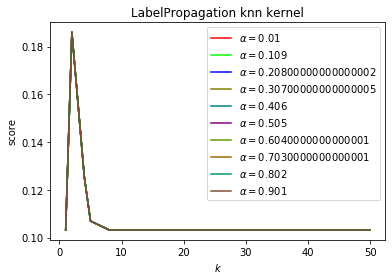

In [19]:
test_LabelPropagation_knn(*data)# 

---1
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3
---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


---4
---5
---2
---3


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


---4
---5


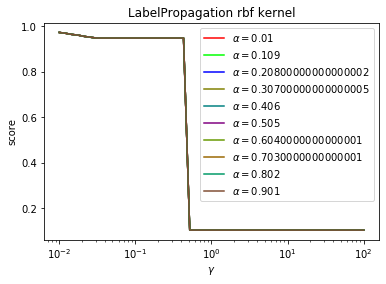

In [20]:
test_LabelPropagation_rbf(*data)# 调用 test_LabelPropagation_rbf